In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 21 16:14:20 2023

@author: poojap

This program will combine transformed proteomic data and the output of the
spatial proteomic analysis with modules specified. The entrez ID and module
membership will also be detailed.

"""
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
currdir = os.getcwd()
parent = os.path.dirname(currdir)
gparent = os.path.dirname(parent)


In [5]:
gene_analyzing = "LRRK2"

transformedfile = f"LOPIT_{gene_analyzing}_young_Transformed.csv"
module_results_file = f"{gene_analyzing}-TMT-Module-Results.xlsx"

# CHANGE TO YOUR VARIABLES
wildtype = "WildType"
mutant = "Transgenic"

mixture_to_analyze = "M1"
significant_module = 7

In [3]:
def ensure_dirs_exists(path):
    if "." in path:
        path = os.path.dirname(path)
    if not os.path.exists(path):
        os.makedirs(path)
    return

In [6]:
def read_files(gene_analyzing, transformedfile, module_results_file):
    # change to point to your directory and appropriate pre-processed file
    transformeddata_df = pd.read_csv(f"{parent}/example_data/transformeddata/{transformedfile}") 
    partition_df = pd.read_excel(f"{parent}/example_data/tables/{module_results_file}")
    return gene_analyzing, transformeddata_df, partition_df

geneAnalysis, transforrmeddatadf, partition_df = read_files(gene_analyzing, transformedfile, module_results_file)

In [7]:
print(transforrmeddatadf.columns)
transforrmeddatadf.head()


Index(['Unnamed: 0', 'Protein', 'Gene', 'Function', 'Origin', 'Mixture',
       'Genotype', 'BioFraction', 'Intensity', 'Abundance', 'Rel_Intensity'],
      dtype='object')


,Unnamed: 0,Protein,Gene,Function,Origin,Mixture,Genotype,BioFraction,Intensity,Abundance,Rel_Intensity
0,0,A0A1W2P872,Nova2,RNA-binding protein Nova-2,Mus musculus,M1,WildType,F4,36.018471,5.170665,0.019121
1,1,A2A3V1,Akap17b,A-kinase anchor protein 17B,Mus musculus,M1,WildType,F4,82.582366,6.367762,0.009993
2,2,A2A5R2,Arfgef2,Brefeldin A-inhibited guanine nucleotide-excha...,Mus musculus,M1,WildType,F4,361.963301,8.499700,0.024606
3,3,A2A690,Tanc2,Protein TANC2,Mus musculus,M1,WildType,F4,695.661714,9.442242,0.022458
4,4,A2A6A1,Gpatch8,G patch domain-containing protein 8,Mus musculus,M1,WildType,F4,116.365049,6.862514,0.009048


In [8]:
partition_df.head()

,UniProt,Entrez,Symbol,Membership
0,A2A5R2,99371,Arfgef2,0
1,E9PY46,106633,Ift140,0
2,O54829,24012,Rgs7,0
3,O70325,625249,Gpx4,0
4,P43274,50709,H1f4,0


In [11]:
def merge_dataframes(transformed_data, partition_module_data):
    alldata = pd.DataFrame()
    alldata = pd.merge(transformed_data, partition_module_data, left_on=("Gene"),
                       right_on = ("Symbol"))
    alldata = alldata.drop(columns=["Symbol", "UniProt"], axis = 1)
    write_to = f"{parent}/example_data/tables/{gene_analyzing}_data_with_membership.csv"
    
    # alldata is shorter than transformed because alldata is filtered to only mus musculus
    alldata.to_csv(write_to, index = False)
    ensure_dirs_exists(write_to)
    return alldata
alldata_df = merge_dataframes(transforrmeddatadf, partition_df)


In [12]:
def drop_irrelevant_cols(alldata_df):
    ##### Time for data analysis ################
    colstodrop = ["Origin", "Function", "Entrez"]
    newdf = alldata_df.drop(colstodrop, axis = 1)
    newdf.head()
    return newdf
newdf = drop_irrelevant_cols(alldata_df)

In [14]:
def pick_module(significant_module):
    # Change below to your significant module sheet!
    sheet_name = "Module Results"
    module_details_df = pd.read_excel(f"{parent}/example_data/tables/{module_results_file}",
                                      sheet_name=sheet_name)
    sigmodules = module_details_df[module_details_df["candidate"] == True]["Module"].values
    print(f"Significant Modules in this dataset: {sigmodules}\n")

    # Handling when a specific module is specified
    if significant_module is not None:
        # Ensuring the module prefix "M" is correctly formatted
        module_id = f"M{significant_module}" if isinstance(significant_module, int) else significant_module
        nprots = int(module_details_df[module_details_df["Module"] == module_id]["nProts"].values[0])
        pAdjustScore = float(module_details_df[module_details_df["Module"] == module_id]["Padjust"].values[0])
        print(f"Number of proteins in module {module_id}: {nprots}\n")
        print(f"PadjustScore for module {module_id}: {pAdjustScore}\n")
    else:
        # Default values when no specific module is specified
        nprots = None
        pAdjustScore = None

    return module_details_df, nprots, pAdjustScore, sigmodules
module_details_df, nprots, pAdjustScore, sign_modules = pick_module(None)

Significant Modules in this dataset: ['M2' 'M8' 'M12' 'M21' 'M4' 'M20' 'M1' 'M33' 'M13' 'M11' 'M9' 'M14' 'M7'
 'M16' 'M36']



In [15]:
def analyze_data(newdf, wildtype, mutant, sigmodule):
    proteins = []
    genes = []
    fractions = []
    mixtures = []
    
    print(f"In this dataset, the wildtype is classified as '{wildtype}' and the mutant is classified as '{mutant}'")
    ##### For some reason some genes not in OG set are added during module <- FIXME
    ## analysis. These extra genes are taken out when mapped to OG data, but
    ### that is why there may be some disecrepancy in the quantity 

    for ind, val in enumerate(newdf["Membership"]):
        if val == sigmodule:
            proteins.append(newdf["Protein"][ind])
            genes.append(newdf["Gene"][ind])
            fractions.append(newdf["BioFraction"][ind])
            mixtures.append(newdf["Mixture"][ind])

    proteins = list(set(proteins))
    genes = list(set(genes))
    fractions = list(set(fractions))
    fractions = sorted(fractions, key=lambda x: int(x.strip('F ').strip()))
    mixtures = list(set(mixtures))
    mixtures = sorted(mixtures, key=lambda x: int(x.strip('M ').strip()))
    return proteins, genes, fractions, mixtures
proteins, genes, fractions, mixtures = analyze_data(newdf, wildtype, mutant, significant_module)
mixtures

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


['M1', 'M2', 'M3']

In [16]:
def pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures):
    wt_dictionary = {}
    for gene in tqdm(genes, desc="iterating through genes in WT proteome"):
        ind = newdf[newdf["Gene"] == gene].index
        gene_mixtures = {}
        for i in ind:
            if newdf["Genotype"][i] == wildtype:
                for mix in mixtures:
                    if newdf["Mixture"][i] == mix:
                        gene_biofractions = []
                        for frac in fractions:
                            val = newdf[(newdf["BioFraction"] == frac) & (newdf["Gene"] == gene) &
                                        (newdf["Genotype"] == wildtype) & (newdf["Mixture"] == mix)]["Rel_Intensity"].values
                            gene_biofractions.extend(val)    
                        gene_mixtures[mix] = gene_biofractions
                wt_dictionary[gene] = gene_mixtures
    return wt_dictionary
wildtype_dict = pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures)

iterating through genes in WT proteome: 100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


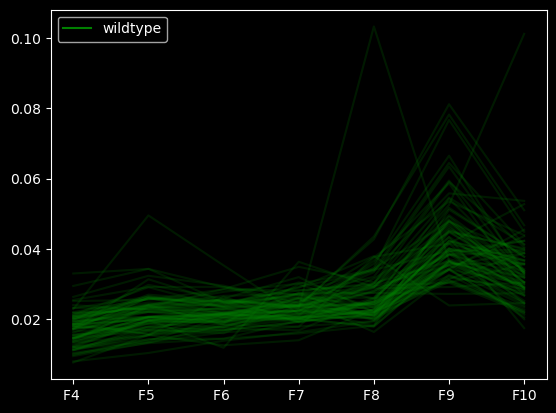

In [17]:
def plot_wt(wildtype_dictionary, fractions, mixture_to_analyze):
    fig, ax = plt.subplots()
    mixturevals = []
    for ind, gene in enumerate(wildtype_dictionary.keys()):
        # only plotting M1, if you would like to pick another mixture you may.
        mixturevals = (list(wildtype_dictionary[gene][mixture_to_analyze]))
        
        ax.plot(fractions, mixturevals, color = "green", alpha = 0.2)
    green_line = plt.Line2D([0], [0], color='green', label='wildtype')
    ax.legend(handles=[green_line])
    return
plot_wt(wildtype_dict, fractions, mixture_to_analyze)

In [18]:
def pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures):
    mut_dictionary = {}
    for gene in tqdm(genes, desc="iterating through genes in MUT proteome"):
        ind = newdf[newdf["Gene"] == gene].index
        gene_mixtures = {}
        for i in ind:
            if newdf["Genotype"][i] == wildtype:
                for mix in mixtures:
                    if newdf["Mixture"][i] == mix:
                        gene_biofractions = []
                        for frac in fractions:
                            val = newdf[(newdf["BioFraction"] == frac) & (newdf["Gene"] == gene) &
                                        (newdf["Genotype"] == mutant) & (newdf["Mixture"] == mix)]["Rel_Intensity"].values
                            gene_biofractions.extend(val)    
                        gene_mixtures[mix] = gene_biofractions
                mut_dictionary[gene] = gene_mixtures
    return mut_dictionary
mutant_dict = pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures)

iterating through genes in MUT proteome: 100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


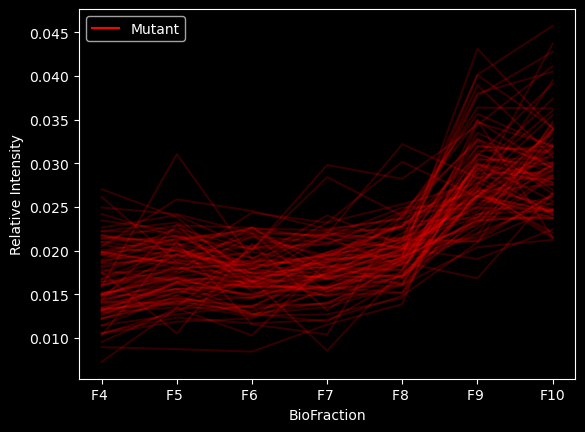

In [19]:
def plot_MUT(mut_dictionary, fractions, mixture_to_analyze):
    ax = plt.gca()
    mut_mixtures = []
    for gene in mut_dictionary.keys():
        # only plotting M1, if you would like to pick another mixture you may.
        mut_mixtures = (list(mut_dictionary[gene][mixture_to_analyze]))
        ax.plot(fractions, mut_mixtures, color = "red", alpha = 0.2)

    red_line = plt.Line2D([0], [0], color='red', label='Mutant')
    ax.legend(handles=[red_line])

    ax.set_xlabel("BioFraction")
    ax.set_ylabel("Relative Intensity") 
    plt.show()
    return
plot_MUT(mutant_dict, fractions, mixture_to_analyze)

In [20]:
## Function for scientific notation
def as_sn(number):
    formatted_number = "{:.2e}".format(number)
    formatted_number = formatted_number.replace('e', 'x10')
    exponent_start = formatted_number.index('x10') + len('x10')
    
    exponent = formatted_number[exponent_start:]
    if "-" in exponent:
        exponent = exponent.translate(str.maketrans('-0123456789', '⁻⁰¹²³⁴⁵⁶⁷⁸⁹'))
    else:
        exponent = exponent.translate(str.maketrans('+0123456789', '⁺⁰¹²³⁴⁵⁶⁷⁸⁹'))


    formatted_number = formatted_number[:exponent_start]  + exponent
    return formatted_number
form = as_sn(1.399393e22)
print(form)


1.40x10⁺²²


In [21]:
nprots

analyzing ONLY mixture M1


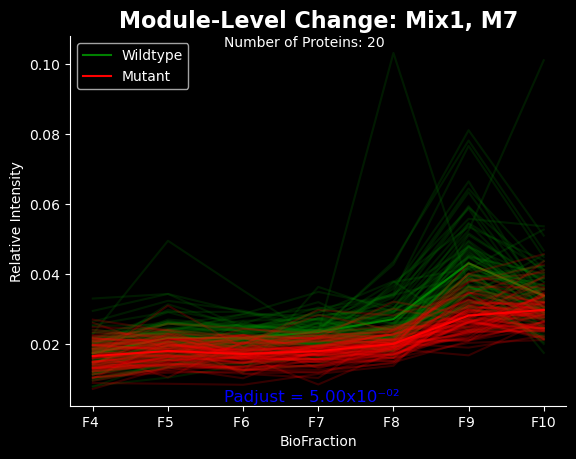

In [22]:
def plot_MUTWT_1mix(wt_dictionary, mut_dictionary, significant_module, pAdjustScore, nProts, fractions, mixture_to_analyze):
    fig, ax = plt.subplots()
    print(f"analyzing ONLY mixture {mixture_to_analyze}")

    WT, Mut = [], []

    # Determine the alpha value based on the number of proteins
    if nProts < 50:
        alpha = 0.2
    elif 50 <= nProts <= 100:
        alpha = 0.1
    else:  # nProts >= 101
        alpha = 0.08

    # Processing Wild Type data
    for gene in wt_dictionary.keys():
        wt_mixturevals = list(wt_dictionary[gene][mixture_to_analyze])
        WT.append(wt_mixturevals)
        ax.plot(fractions, wt_mixturevals, color="green", alpha=alpha)
    WT_average = np.mean(WT, axis=0)
    ax.plot(fractions, WT_average, color="green")

    # Processing Mutant data
    for gene in mut_dictionary.keys():
        mut_mixtures = list(mut_dictionary[gene][mixture_to_analyze])
        Mut.append(mut_mixtures)
        ax.plot(fractions, mut_mixtures, color="red", alpha=alpha)
    MUT_average = np.mean(Mut, axis=0)
    ax.plot(fractions, MUT_average, color="red")

    # Add legends
    green_line = plt.Line2D([0], [0], color='green', label='Wildtype')
    red_line = plt.Line2D([0], [0], color='red', label='Mutant')
    ax.legend(handles=[green_line, red_line])

    directory = f"{gene_analyzing}_Mixture{mixture_to_analyze}"
    
    strip_mixture_number = lambda x: int(x.strip('M '))

    # Plot formatting and saving
    ax.set_xlabel("BioFraction")
    ax.set_ylabel("Relative Intensity")  # FIXME: Needs normalization to log2scale
    ax.set_title(f"Module-Level Change: Mix{strip_mixture_number(mixture_to_analyze)}, M{significant_module}", fontsize=16, fontweight="bold")
    ymin, ymax = plt.ylim()
    plt.text(1.75, ymin + 0.001, f'Padjust = {as_sn(float(pAdjustScore))}', fontsize=12, color='blue')
    plt.text(1.75, ymax - 0.003, f"Number of Proteins: {nProts}", fontsize=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    savefigure = f"{directory}/{gene_analyzing}_Module{significant_module}_Mixture{mixture_to_analyze}.png"
    ensure_dirs_exists(savefigure)
    plt.savefig(savefigure)
    
    
    return WT, Mut, mixture_to_analyze
WT, MUT, mixture_to_analyze = plot_MUTWT_1mix(wildtype_dict, mutant_dict, significant_module, 0.05, 20, fractions,
                                              mixture_to_analyze)

Analyzing ALL mixtures: ['M1', 'M2', 'M3']
LRRK2_MixturesAveraged/LRRK2_Module5_MixturesAveraged.png file created at /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/LRRK2_MixturesAveraged/LRRK2_Module5_MixturesAveraged.png


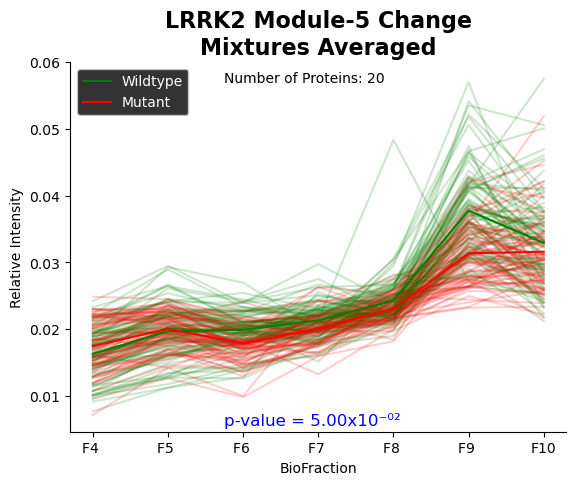

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os

def find_avg_plots(wt_dictionary, mut_dictionary, significant_module, pAdjustScore, nProts, mixtures):
    """
    Generates and saves a plot showing the average data for wildtype and mutant across mixtures.
    
    :param wt_dictionary: Dictionary containing wildtype data.
    :param mut_dictionary: Dictionary containing mutant data.
    :param significant_module: Module number considered significant for analysis.
    :param pAdjustScore: P-adjust score for annotation.
    :param nProts: Number of proteins.
    :param mixtures: List of mixtures to analyze.
    """
    print(f"Analyzing ALL mixtures: {mixtures}")
    WT_all, MUT_all = [], []

    # Processing data
    for mix in mixtures:
        WT = [list(wt_dictionary[gene][mix]) for gene in wt_dictionary.keys()]
        Mut = [list(mut_dictionary[gene][mix]) for gene in mut_dictionary.keys()]
        WT_all.append(WT)
        MUT_all.append(Mut)

    WT_average = np.mean(WT_all, axis=0)
    MUT_average = np.mean(MUT_all, axis=0)
    WT_singular_average = np.mean(WT_average, axis=0)
    MUT_singular_average = np.mean(MUT_average, axis=0)

    # Plotting
    fig, ax = plt.subplots()
    alpha_values = {50: 0.195, 100: 0.18, float('inf'): 0.08}
    alpha = next(val for n, val in alpha_values.items() if nProts <= n)

    for ind, wtvals in enumerate(WT_average):
        ax.plot(fractions, wtvals, color='green', alpha=alpha)
        ax.plot(fractions, MUT_average[ind], color='red', alpha=alpha)
    ax.plot(fractions, WT_singular_average, color='green')
    ax.plot(fractions, MUT_singular_average, color='red')

    ax.legend(handles=[plt.Line2D([0], [0], color=color, label=label) for color, label in [('green', 'Wildtype'), ('red', 'Mutant')]])


    ax.set_xlabel("BioFraction", color='black')
    ax.set_ylabel("Relative Intensity", color='black')  ## FIXME -> needs to be normalized log2scale to be between 0-1
    ax.set_facecolor('white')
    
    # Set the spine color to black
    for spine in ax.spines.values():
        spine.set_color('black')
    ymin, ymax = plt.ylim()

    # Set the tick color to black
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_title(f"{gene_analyzing} Module-{significant_module} Change\nMixtures Averaged", fontsize = 16, fontweight = "bold", color='black')
    ax.text(1.75, max(ax.get_ylim()) - 0.003, f"Number of Proteins: {nProts}", fontsize=10)
    ax.text(1.75, min(ax.get_ylim()) + 0.001, f'p-value = {as_sn(float(pAdjustScore))}', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')  # Ensure the entire figure background is white

    plt.text(1.75, ymax - 0.003, f"Number of Proteins: {nProts}", fontsize=10, color='black')
    plt.text(1.75 , ymin + 0.001, f'p-value = {as_sn(float(pAdjustScore))}', fontsize=12, color='blue')

    # Saving the figure
    directory = f"{gene_analyzing}_MixturesAveraged"
    savefigure = f"{directory}/{gene_analyzing}_Module{significant_module}_MixturesAveraged.png"
    ensure_dirs_exists(savefigure)
    plt.savefig(savefigure, facecolor='white', edgecolor='white', bbox_inches='tight')
    
    print(f"{savefigure} file created at {os.path.abspath(savefigure)}")
    plt.show()
    return
# Example usage
find_avg_plots(wildtype_dict, mutant_dict, 5, 0.05, 20, mixtures)


In [30]:
import re
def main():
    global mixture_to_analyze, gene_analyzing, foldername, currentdir, abspath, transformedfile, module_results_file
    global wildtype, mutant, proteins, fractions, genes, mixtures

    average_mixtures = True  # True to average all mixtures
    mixture_to_analyze = "M3"  # Specify mixture; ignored if averaging
    significant_module = None  # None to analyze all modules

    # Common initial steps
    geneAnalysis, transformeddatadf, partition_df = read_files(gene_analyzing, transformedfile, module_results_file)
    alldata_df = merge_dataframes(transformeddatadf, partition_df)
    newdf = drop_irrelevant_cols(alldata_df)

    # Determine modules to analyze
    module_details_df, nprots, pAdjustScore, sigmodules = pick_module(None)
    sigmodules = [int(re.search(r'\d+', element).group()) for element in sigmodules if re.search(r'\d+', element)]
    print("modules to analyze", sigmodules)
    for module in sigmodules:
        print(module)
        print(f"Mixture analyzing {mixture_to_analyze}")
        print(f"Moving to next module {module} \n")
        module_details_df, nprots, pAdjustScore, sigmodules = pick_module(module)
        proteins, genes, fractions, mixtures = analyze_data(newdf, wildtype, mutant, module)
        wildtype_dict = pull_Module_WT_data(newdf, proteins, genes, fractions, mixtures)
        plot_wt(wildtype_dict,fractions, mixture_to_analyze)
        mutant_dict = pull_Module_MUT_data(newdf, proteins, genes, fractions, mixtures)
        plot_MUT(mutant_dict, fractions, mixture_to_analyze)

        if average_mixtures:
            print(f"Averaging all mixtures, and creating plot of averages for module {module}.")
            find_avg_plots(wildtype_dict, mutant_dict, module, pAdjustScore, nprots, mixtures)
        else:
            print(f"Plotting only mixture {mixture_to_analyze} for module {module}.")
            WT, MUT, mixture_to_analyze = plot_MUTWT_1mix(wildtype_dict, mutant_dict, module, pAdjustScore, nprots, mixture_to_analyze)

    return

Significant Modules in this dataset: ['M2' 'M8' 'M12' 'M21' 'M4' 'M20' 'M1' 'M33' 'M13' 'M11' 'M9' 'M14' 'M7'
 'M16' 'M36']

modules to analyze [2, 8, 12, 21, 4, 20, 1, 33, 13, 11, 9, 14, 7, 16, 36]
2
Mixture analyzing M3
Moving to next module 2 

Significant Modules in this dataset: ['M2' 'M8' 'M12' 'M21' 'M4' 'M20' 'M1' 'M33' 'M13' 'M11' 'M9' 'M14' 'M7'
 'M16' 'M36']

Number of proteins in module M2: 133

PadjustScore for module M2: 2.431047022425051e-24

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


iterating through genes in MUT proteome: 100%|██████████| 129/129 [02:20<00:00,  1.09s/it]


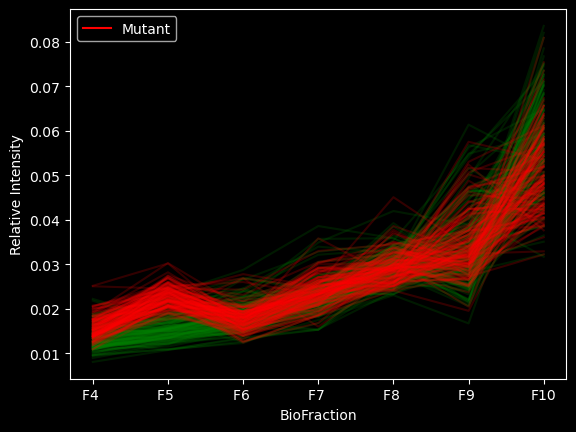

Averaging all mixtures, and creating plot of averages for module 2.
Analyzing ALL mixtures: ['M1', 'M2', 'M3']
LRRK2_MixturesAveraged/LRRK2_Module2_MixturesAveraged.png file created at /home/poojaparameswaran/Documents/SoderlingLab/SpatialProteomics/compare_MutvsWTfractions/LRRK2_MixturesAveraged/LRRK2_Module2_MixturesAveraged.png


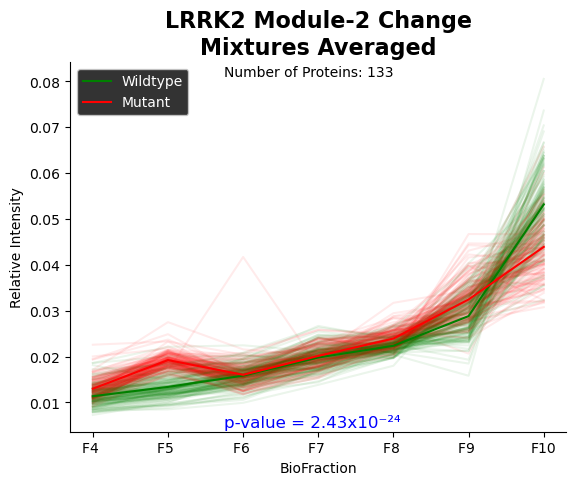

8
Mixture analyzing M3
Moving to next module 8 

Significant Modules in this dataset: ['M2' 'M8' 'M12' 'M21' 'M4' 'M20' 'M1' 'M33' 'M13' 'M11' 'M9' 'M14' 'M7'
 'M16' 'M36']

Number of proteins in module M8: 80

PadjustScore for module M8: 6.782710914990982e-17

In this dataset, the wildtype is classified as 'WildType' and the mutant is classified as 'Transgenic'


iterating through genes in WT proteome:  29%|██▉       | 23/79 [00:24<01:00,  1.08s/it]

In [31]:
if __name__ == "__main__":

    main()